<a href="https://colab.research.google.com/github/kreitika/AIS-Maritime-Anomaly-Detection-Project/blob/main/AIS_Maritime_Anomaly_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Creating a realistic AIS sample dataset with:
# 2 vessels
# normal movement + sudden anomalies (speed jumps / sharp turns)

data = {
    "mmsi": [
        205123000,205123000,205123000,205123000,205123000,
        244880000,244880000,244880000,244880000,244880000
    ],
    "timestamp": [
        "2024-01-01 00:00:00",
        "2024-01-01 00:10:00",
        "2024-01-01 00:20:00",
        "2024-01-01 00:30:00",
        "2024-01-01 00:40:00",
        "2024-01-01 00:00:00",
        "2024-01-01 00:10:00",
        "2024-01-01 00:20:00",
        "2024-01-01 00:30:00",
        "2024-01-01 00:40:00",
    ],
    "lat": [
        51.20, 51.25, 51.30, 51.34, 51.35,
        52.10, 52.12, 52.13, 52.14, 52.16
    ],
    "lon": [
        4.40, 4.42, 4.45, 4.48, 4.50,
        4.15, 4.18, 4.18, 4.20, 4.25
    ],
    "sog": [12.5, 13.0, 15.5, 3.0, 12.0,    # vessel 1
            8.0, 8.2, 8.1, 27.0, 1.0],      # vessel 2 — anomalies here
    "cog": [80, 82, 120, 150, 151,
            20, 21, 22, 90, 10]
}

df = pd.DataFrame(data)
df.to_csv("ais_dataset.csv", index=False)

# Give user a clickable link
from google.colab import files
files.download("ais_dataset.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# Installing only what I actually need
!pip install folium geopy --quiet

import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

print("Imports loaded.")


Imports loaded.


In [3]:
# Cell 2 --- Uploading the AIS CSV file

from google.colab import files
import pandas as pd

# Prompting file upload (I will just select ais_sample.csv manually)
uploaded = files.upload()

# Getting the filename from the uploaded dict
file_name = list(uploaded.keys())[0]

# Loading the CSV into a dataframe
df = pd.read_csv(file_name)

print("Loaded:", file_name, " | Rows:", len(df))
df.head()


Saving ais_dataset.csv to ais_dataset (1).csv
Loaded: ais_dataset (1).csv  | Rows: 10


,mmsi,timestamp,lat,lon,sog,cog
0,205123000,2024-01-01 00:00:00,51.20,4.40,12.5,80
1,205123000,2024-01-01 00:10:00,51.25,4.42,13.0,82
2,205123000,2024-01-01 00:20:00,51.30,4.45,15.5,120
3,205123000,2024-01-01 00:30:00,51.34,4.48,3.0,150
4,205123000,2024-01-01 00:40:00,51.35,4.50,12.0,151


In [4]:
# Dropping rows where core columns are missing
df = df.dropna(subset=["mmsi", "timestamp", "lat", "lon", "sog", "cog"])

# Remove crazy coordinates just in case
df = df[(df["lat"].between(-90, 90)) & (df["lon"].between(-180, 180))]

# Speed sanity filter — merchant ships rarely exceed 60 knots
df = df[df["sog"].between(0, 60)]

# Convert timestamp → datetime, and sort by vessel id
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(["mmsi", "timestamp"]).reset_index(drop=True)

df.head()


,mmsi,timestamp,lat,lon,sog,cog
0,205123000,2024-01-01 00:00:00,51.20,4.40,12.5,80
1,205123000,2024-01-01 00:10:00,51.25,4.42,13.0,82
2,205123000,2024-01-01 00:20:00,51.30,4.45,15.5,120
3,205123000,2024-01-01 00:30:00,51.34,4.48,3.0,150
4,205123000,2024-01-01 00:40:00,51.35,4.50,12.0,151


In [5]:
# Haversine distance (km) — simple formula for distance between two GPS points
from math import radians, sin, cos, sqrt, atan2

R = 6371  # km

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*(sin(dlon/2)**2)
    return 2 * R * atan2(sqrt(a), sqrt(1-a))

# Apply feature engineering per vessel
all_vessels = []

for mmsi, g in df.groupby("mmsi"):
    g = g.sort_values("timestamp").copy()

    # time difference in hours
    g["dt"] = g["timestamp"].diff().dt.total_seconds() / 3600

    # distance travelled (km)
    g["dist_km"] = [
        haversine(g.iloc[i-1].lat, g.iloc[i-1].lon,
                  g.iloc[i].lat, g.iloc[i].lon)
        if i > 0 else np.nan
        for i in range(len(g))
    ]

    # estimated speed from distance (km/h)
    g["spd_est"] = g["dist_km"] / g["dt"]

    # acceleration (km/h²)
    g["accel"] = g["spd_est"].diff() / g["dt"]

    # turn rate (°/hr) — adjusting wrap-around at 360°
    dc = (g["cog"] - g["cog"].shift(1) + 180) % 360 - 180
    g["turn_rate"] = dc / g["dt"]

    all_vessels.append(g)

df_feat = pd.concat(all_vessels, ignore_index=True)

# Clean up NaN/inf
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)
df_feat = df_feat.dropna(subset=["dist_km", "spd_est", "accel", "turn_rate", "dt"])
df_feat = df_feat[df_feat["dt"] > 0]

df_feat.head()


,mmsi,timestamp,lat,lon,sog,cog,dt,dist_km,spd_est,accel,turn_rate
2,205123000,2024-01-01 00:20:00,51.30,4.45,15.5,120,0.166667,5.938495,35.630969,7.450463,228.0
3,205123000,2024-01-01 00:30:00,51.34,4.48,3.0,150,0.166667,4.912160,29.472957,-36.948070,180.0
4,205123000,2024-01-01 00:40:00,51.35,4.50,12.0,151,0.166667,1.779344,10.676064,-112.781359,6.0
7,244880000,2024-01-01 00:20:00,52.13,4.18,8.1,22,0.166667,1.111949,6.671696,-68.823887,6.0
8,244880000,2024-01-01 00:30:00,52.14,4.20,27.0,90,0.166667,1.760612,10.563670,23.351849,408.0


In [6]:
# Features I want to feed into the anomaly detector
feature_cols = ["sog", "spd_est", "accel", "turn_rate"]

X = df_feat[feature_cols].values

# Normalizing because different units = bad for IF
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature matrix shape:", X_scaled.shape)


Feature matrix shape: (6, 4)


In [7]:
# Isolation Forest — unsupervised anomaly detection
iso = IsolationForest(
    n_estimators=200,
    contamination=0.08,  # since small dataset, I'll set this slightly bigger
    random_state=42
)

iso.fit(X_scaled)

# Predict anomalies
scores = iso.decision_function(X_scaled)
labels = iso.predict(X_scaled)  # -1 = anomaly

df_feat["anomaly_score"] = -scores          # flip so higher = more "weird"
df_feat["is_anomaly"] = (labels == -1)

df_feat.head()


,mmsi,timestamp,lat,lon,sog,cog,dt,dist_km,spd_est,accel,turn_rate,anomaly_score,is_anomaly
2,205123000,2024-01-01 00:20:00,51.30,4.45,15.5,120,0.166667,5.938495,35.630969,7.450463,228.0,-0.070257,False
3,205123000,2024-01-01 00:30:00,51.34,4.48,3.0,150,0.166667,4.912160,29.472957,-36.948070,180.0,-0.089244,False
4,205123000,2024-01-01 00:40:00,51.35,4.50,12.0,151,0.166667,1.779344,10.676064,-112.781359,6.0,-0.082074,False
7,244880000,2024-01-01 00:20:00,52.13,4.18,8.1,22,0.166667,1.111949,6.671696,-68.823887,6.0,-0.098203,False
8,244880000,2024-01-01 00:30:00,52.14,4.20,27.0,90,0.166667,1.760612,10.563670,23.351849,408.0,-0.025452,False


In [8]:
# Picking top K anomalies
K = 10
top = df_feat.nlargest(K, "anomaly_score")

# Use median lat/lon to center the map
center_lat = df_feat["lat"].median()
center_lon = df_feat["lon"].median()

m = folium.Map(location=[center_lat, center_lon], zoom_start=7)

# Plot anomalies
for _, r in top.iterrows():
    folium.CircleMarker(
        location=[r.lat, r.lon],
        radius=5,
        color="red",
        fill=True,
        popup=f"mmsi={r.mmsi}, score={r.anomaly_score:.2f}"
    ).add_to(m)

m


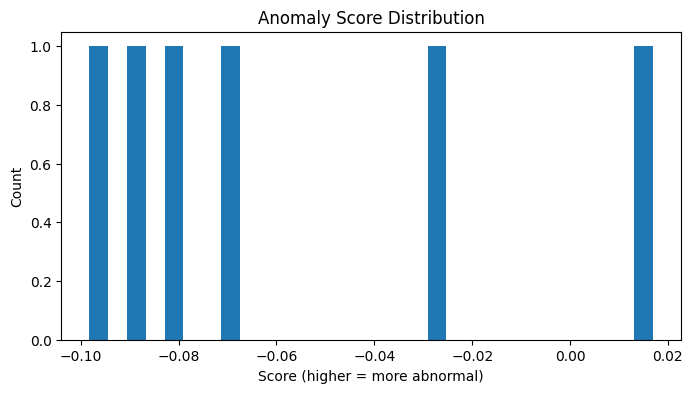

Anomaly rate: 0.16666666666666666


In [9]:
plt.figure(figsize=(8,4))
plt.hist(df_feat["anomaly_score"], bins=30)
plt.title("Anomaly Score Distribution")
plt.xlabel("Score (higher = more abnormal)")
plt.ylabel("Count")
plt.show()

print("Anomaly rate:", df_feat["is_anomaly"].mean())


In [10]:
df_feat.to_csv("ais_anomaly_output.csv", index=False)
print("Saved as ais_anomaly_output.csv")


Saved as ais_anomaly_output.csv


In [11]:
df_feat["is_anomaly"].value_counts(normalize=True)


,proportion
is_anomaly,
False,0.833333
True,0.166667
